In [1]:
import os
import pandas as pd
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import statsmodels.api as sm
from tqdm import tqdm

INPUTS_PATH = os.path.join(os.getcwd(), 'data', 'inputs')

### Experiment Parameters

In [2]:
SPOTS = [
  'USDSGD', 'USDKRW', 'USDMYR', 'USDCNY', 'USDTHB',
  'USDIDR', 'USDTWD', 'USDINR', 'USDJPY'
  # 'USDAUD', 'USDEUR', 'USDGBP'
]

FWD_NAMES = [
  '1M', '2M', '3M', '6M', '12M', '2Y'
]

FWD_NAMES_MAPPINGS = {
  '1M': 1, '2M': 2, '3M': 3, '6M': 6, '12M': 12, '2Y': 24
}

TRAIN_END_DATE = '2005-01-01'

ADD_INTERCEPT = False

### Load Dataset

In [3]:
forwards = {}
spots = []
for ccy in SPOTS:
    # read spot and forward data
    tmp_daily_df = pd.read_excel(os.path.join(INPUTS_PATH, 'daily-currencies-forwards.xlsx'), sheet_name=ccy)
    tmp_daily_df['date'] = pd.to_datetime(tmp_daily_df['date'])
    tmp_daily_df.set_index('date', inplace=True)

    # resample to monthly frequency
    tmp_daily_df = tmp_daily_df.resample('D').last()
    tmp_df = tmp_daily_df.resample('ME').last()

    forwards[ccy] = tmp_df
    spots.append(tmp_df[[f'{ccy} Curncy']])
spots_df = pd.concat(spots, axis=1).dropna()
zscore_spots_df = ((spots_df - spots_df.rolling(window=9).mean()) / (spots_df.rolling(window=9).std() + 1e-6)).dropna()

In [4]:
zscore_spots_df.corr()

,USDSGD Curncy,USDKRW Curncy,USDMYR Curncy,USDCNY Curncy,USDTHB Curncy,USDIDR Curncy,USDTWD Curncy,USDINR Curncy,USDJPY Curncy
USDSGD Curncy,1.000000,0.623622,0.680928,0.255637,0.659274,0.450970,0.592921,0.527639,0.491412
USDKRW Curncy,0.623622,1.000000,0.505092,0.148325,0.530779,0.373661,0.602019,0.483041,0.319007
USDMYR Curncy,0.680928,0.505092,1.000000,0.363550,0.578589,0.421933,0.473191,0.428212,0.305270
USDCNY Curncy,0.255637,0.148325,0.363550,1.000000,0.182045,0.110635,0.186912,0.079586,0.027028
USDTHB Curncy,0.659274,0.530779,0.578589,0.182045,1.000000,0.520009,0.491016,0.497407,0.456540
USDIDR Curncy,0.450970,0.373661,0.421933,0.110635,0.520009,1.000000,0.442696,0.392345,0.297885
USDTWD Curncy,0.592921,0.602019,0.473191,0.186912,0.491016,0.442696,1.000000,0.442481,0.401929
USDINR Curncy,0.527639,0.483041,0.428212,0.079586,0.497407,0.392345,0.442481,1.000000,0.233071
USDJPY Curncy,0.491412,0.319007,0.305270,0.027028,0.456540,0.297885,0.401929,0.233071,1.000000


### Test for the Number of Contegration Vectors

In [5]:
johansen_test = coint_johansen(
    endog=spots_df.loc["2000-01-01":],
    det_order=0,
    k_ar_diff=1
)

trace_stats = pd.DataFrame(johansen_test.max_eig_stat)
trace_cv = pd.DataFrame(johansen_test.max_eig_stat_crit_vals)
trace_stats = pd.concat([trace_stats, trace_cv], axis=1)
trace_stats.index = [f'r <= {i}' for i in range(len(trace_stats))]
trace_stats.columns = ['Eigenvalue Stat', '10%', '5%', '1%']

trace_stats

,Eigenvalue Stat,10%,5%,1%
r <= 0,59.046031,55.2412,58.4332,64.9960
r <= 1,39.405773,49.2855,52.3622,58.6634
r <= 2,23.185819,43.2947,46.2299,52.3069
r <= 3,20.715648,37.2786,40.0763,45.8662
r <= 4,17.530240,31.2379,33.8777,39.3693
r <= 5,12.974467,25.1236,27.5858,32.7172
r <= 6,7.998042,18.8928,21.1314,25.8650
r <= 7,6.471854,12.2971,14.2639,18.5200
r <= 8,0.139128,2.7055,3.8415,6.6349


### Expanding Window OLS Estimation

In [7]:
train_df = spots_df.loc["2000-01-01":TRAIN_END_DATE]
T = spots_df.shape[0] - train_df.shape[0]

ols_pred = {}
forward1m_pred = {}
forward2m_pred = {}
forward3m_pred = {}
forward6m_pred = {}
forward12m_pred = {}
forward2y_pred = {}
spots_rw_pred = {}
for ccy in SPOTS:
    ols_pred[ccy] = pd.Series(index=spots_df.iloc[(train_df.shape[0]):].index, name=f"{ccy} Curncy")
    forward1m_pred[ccy] = pd.Series(index=spots_df.iloc[(train_df.shape[0]):].index, name=f"{ccy} 1M")
    forward2m_pred[ccy] = pd.Series(index=spots_df.iloc[(train_df.shape[0]):].index, name=f"{ccy} 2M")
    forward3m_pred[ccy] = pd.Series(index=spots_df.iloc[(train_df.shape[0]):].index, name=f"{ccy} 3M")
    forward6m_pred[ccy] = pd.Series(index=spots_df.iloc[(train_df.shape[0]):].index, name=f"{ccy} 6M")
    forward12m_pred[ccy] = pd.Series(index=spots_df.iloc[(train_df.shape[0]):].index, name=f"{ccy} 12M")
    forward2y_pred[ccy] = pd.Series(index=spots_df.iloc[(train_df.shape[0]):].index, name=f"{ccy} 2Y")
    spots_rw_pred[ccy] = pd.Series(index=spots_df.iloc[(train_df.shape[0]):].index, name=f"{ccy} Curncy")

for step in tqdm(range(0, T), desc="Running Expanding Window OLS..."):
    t = train_df.shape[0] + step
    tmp_train_df = spots_df.iloc[:t]
    tmp_test_df = spots_df.iloc[t-1:t]

    for ccy in SPOTS:
        y = tmp_train_df[f"{ccy} Curncy"].values
        X = tmp_train_df.drop(columns=[f"{ccy} Curncy"]).values
        X_test = tmp_test_df.drop(columns=[f"{ccy} Curncy"]).values
        
        if ADD_INTERCEPT:
            X = sm.add_constant(X)
        
        # fit model
        model = sm.OLS(y, X)
        results = model.fit()

        # ols predict test
        if ADD_INTERCEPT:
            X_test = sm.add_constant(X_test)
        y_pred = results.predict(X_test)
        y_pred = pd.Series(y_pred, index=tmp_test_df.index, name=f"{ccy} Curncy")
        ols_pred[ccy].iloc[step] = y_pred.iloc[0]

        # random walk predict test
        y_pred = pd.Series(y[-1], index=tmp_test_df.index, name=f"{ccy} Curncy")
        spots_rw_pred[ccy].iloc[step] = y_pred.iloc[0]

        # forward predict test
        for fwd in FWD_NAMES:
            fwd_name = f"{ccy} {fwd}"
            fwd_pred = forwards[ccy].loc[tmp_test_df.index[0]][f"{ccy}{fwd} Curncy"]
            if fwd == '1M':
                forward1m_pred[ccy].iloc[step] = fwd_pred
            elif fwd == '2M':
                forward2m_pred[ccy].iloc[step] = fwd_pred
            elif fwd == '3M':
                forward3m_pred[ccy].iloc[step] = fwd_pred
            elif fwd == '6M':
                forward6m_pred[ccy].iloc[step] = fwd_pred
            elif fwd == '12M':
                forward12m_pred[ccy].iloc[step] = fwd_pred
            elif fwd == '2Y':
                forward2y_pred[ccy].iloc[step] = fwd_pred

Running Expanding Window OLS...: 100%|██████████| 327/327 [00:05<00:00, 57.92it/s]


In [ ]:
all_rmse = []
for ccy in SPOTS:

    true = spots_df.loc[TRAIN_END_DATE:][[f"{ccy} Curncy"]].copy().dropna()
    true.columns = [f"{ccy} True"]

    pred_ols = pd.DataFrame(ols_pred[ccy])
    pred_ols.columns = [f"{ccy} OLS"]

    pred_rw = pd.DataFrame(spots_rw_pred[ccy])
    pred_rw.columns = [f"{ccy} RW"]

    pred_1m = pd.DataFrame(forward1m_pred[ccy])
    pred_2m = pd.DataFrame(forward2m_pred[ccy]).shift(1)
    pred_3m = pd.DataFrame(forward3m_pred[ccy]).shift(2)
    pred_6m = pd.DataFrame(forward6m_pred[ccy]).shift(5)
    pred_12m = pd.DataFrame(forward12m_pred[ccy]).shift(11)
    pred_2y = pd.DataFrame(forward2y_pred[ccy]).shift(23)

    pred_compare = pd.concat([
        true,
        pred_ols,
        pred_rw,
        pred_1m,
        pred_2m,
        pred_3m,
        pred_6m,
        pred_12m,
        pred_2y
    ], axis=1).dropna()

    # compute rmse of true vs ols, rw, and forwards
    rmse_ols = ((pred_compare[f"{ccy} True"] - pred_compare[f"{ccy} OLS"]) ** 2).mean() ** 0.5
    rmse_rw = ((pred_compare[f"{ccy} True"] - pred_compare[f"{ccy} RW"]) ** 2).mean() ** 0.5
    rmse_1m = ((pred_compare[f"{ccy} True"] - pred_compare[f"{ccy} 1M"]) ** 2).mean() ** 0.5
    rmse_2m = ((pred_compare[f"{ccy} True"] - pred_compare[f"{ccy} 2M"]) ** 2).mean() ** 0.5
    rmse_3m = ((pred_compare[f"{ccy} True"] - pred_compare[f"{ccy} 3M"]) ** 2).mean() ** 0.5
    rmse_6m = ((pred_compare[f"{ccy} True"] - pred_compare[f"{ccy} 6M"]) ** 2).mean() ** 0.5
    rmse_12m = ((pred_compare[f"{ccy} True"] - pred_compare[f"{ccy} 12M"]) ** 2).mean() ** 0.5
    rmse_2y = ((pred_compare[f"{ccy} True"] - pred_compare[f"{ccy} 2Y"]) ** 2).mean() ** 0.5

    # build ratios of rmse vs rw
    rmse_ols_ratio = rmse_ols / rmse_rw
    rmse_1m_ratio = rmse_1m / rmse_rw
    rmse_2m_ratio = rmse_2m / rmse_rw
    rmse_3m_ratio = rmse_3m / rmse_rw
    rmse_6m_ratio = rmse_6m / rmse_rw
    rmse_12m_ratio = rmse_12m / rmse_rw
    rmse_2y_ratio = rmse_2y / rmse_rw
    rmse_df = pd.DataFrame({
        'RMSE': [
            rmse_rw, rmse_ols, rmse_1m, rmse_2m, rmse_3m, rmse_6m, rmse_12m, rmse_2y
        ],
    }, index=[
        'RW', 'OLS', '1M', '2M', '3M', '6M', '12M', '2Y'
    ])
    rmse_df['ccy'] = ccy

    all_rmse.append(rmse_df)
all_rmse_df = pd.concat(all_rmse, axis=0)

In [182]:
table = all_rmse_df.reset_index().pivot_table(index=['index'], columns=['ccy'], values='RMSE')

# reorder index
table = table.reindex([
    'RW', 'OLS', '1M', '2M', '3M', '6M', '12M', '2Y'
])

table

ccy,USDCNY,USDIDR,USDINR,USDJPY,USDKRW,USDMYR,USDSGD,USDTHB,USDTWD
index,,,,,,,,,
RW,0.073486,314.570577,1.255828,2.954605,39.540488,0.084866,0.022585,0.659531,0.445094
OLS,0.558351,794.308392,5.963095,12.659360,108.028122,0.186476,0.076132,2.426966,1.889258
1M,0.076779,320.134123,1.260183,2.960233,38.990799,0.084274,0.022500,0.663188,0.450717
2M,0.116509,473.914905,1.772383,4.400188,53.963170,0.119506,0.031205,0.968341,0.687338
3M,0.148328,586.158354,2.120704,5.572136,61.831038,0.147602,0.037251,1.210254,0.869510
6M,0.217837,896.523112,2.998073,8.008330,87.049662,0.208714,0.052957,1.694449,1.269377
12M,0.291416,1255.429589,4.151928,11.136016,120.688861,0.273478,0.067173,2.197547,1.690631
2Y,0.385512,3785.621816,5.078471,16.736897,156.879327,0.380537,0.091221,3.307924,2.282491


<Axes: title={'center': 'Spot vs OLS vs RW vs 1M Forward (USDSGD)'}, xlabel='date'>

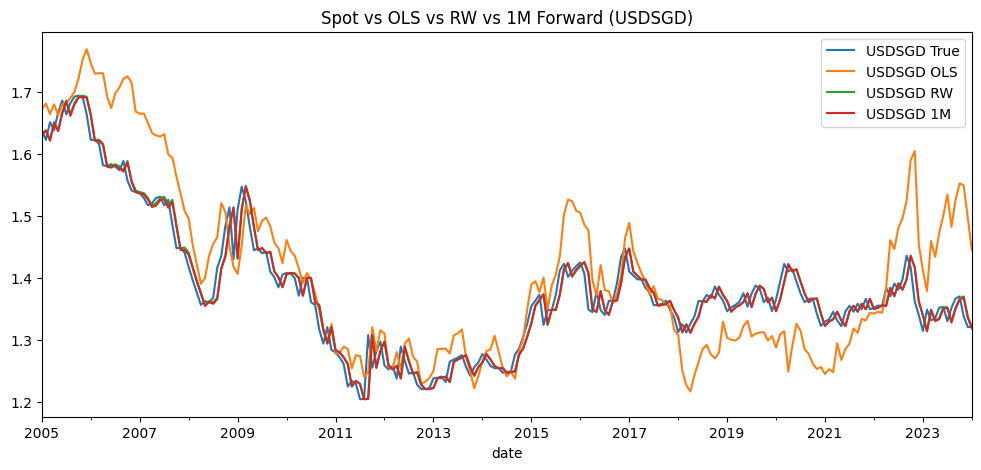

In [157]:
pred_compare.plot(figsize=(12, 5), title=f"Spot vs OLS vs RW vs 1M Forward ({ccy})")